# Doppler Solve: Bilinear

## Setup

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import starry

starry.config.lazy = False
starry.config.quiet = True

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import starry
import george

In [5]:
def generate(
    nc=1,
    show=True,
    flux_err=1e-4,
    ydeg=15,
    u=[0.5, 0.25],
    nt=16,
    inc=40,
    veq=60000,
    smoothing=0.075,
    **kwargs
):

    # Instantiate
    wav = np.linspace(642.85, 643.15, 200)
    map = starry.DopplerMap(
        lazy=False,
        ydeg=ydeg,
        udeg=len(u),
        nc=nc,
        veq=veq,
        inc=inc,
        nt=nt,
        wav=wav,
    )

    # Limb darkening (TODO: fix __setitem__)
    map._u = np.append([-1.0], u)

    # Component surface images
    if nc == 1:
        images = ["spot"]
    elif nc == 2:
        images = ["star", "spot"]
    else:
        raise NotImplementedError("")

    # Component spectra
    if nc == 1:
        mu = np.array([643.0])
    elif nc == 2:
        mu = np.array([643.025, 642.975])
    else:
        raise NotImplementedError("")
    sig = 0.0085
    dw = map.wav0.reshape(1, -1) - mu.reshape(-1, 1)
    spectra = (1.0 - np.exp(-0.5 * dw ** 2 / sig ** 2))[:nc]

    # Load the component maps
    map.load(maps=images, spectra=spectra, smoothing=smoothing)

    # Show
    if show:
        for n in range(map.nc):
            map.show(n=n, projection="moll")

    # Generate unnormalized data
    flux0 = map.flux(normalize=False)
    flux0 += flux_err * np.random.randn(*flux0.shape)

    # Generate normalized data
    flux = map.flux(normalize=True)
    flux += flux_err * np.random.randn(*flux.shape)

    return map, map.y, map.spectrum, flux0, flux


def reset_spectrum(map):
    map._spectrum = np.ones((map.nc, map.nw0_))


def reset_map(map):
    map._y = np.zeros((map.Ny, map.nc))
    map._y[0] = 1.0


def show_spectra(map):
    for n in range(map.nc):
        plt.figure()
        plt.plot(map.wav0, map.spectrum[n], label="inferred")
        plt.plot(map.wav0, spectrum[n], label="true")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("intensity")
        plt.legend()


def show_maps(map):
    for n in range(map.nc):
        map.show(n=n, projection="moll")

## Solve for the spectrum

### One component

#### Generate the data

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


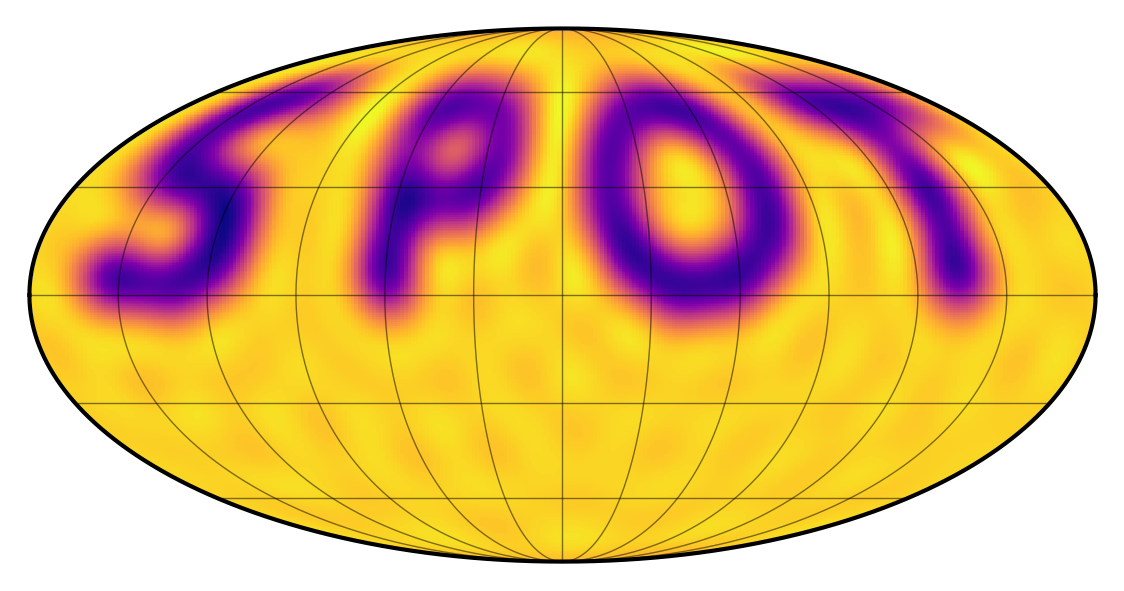

In [6]:
settings = dict(
    flux_err=1e-4, ydeg=15, nt=16, inc=40, veq=60000, smoothing=0.075
)
map, y, spectrum, flux0, flux = generate(nc=1, **settings)

#### Unnormalized solve

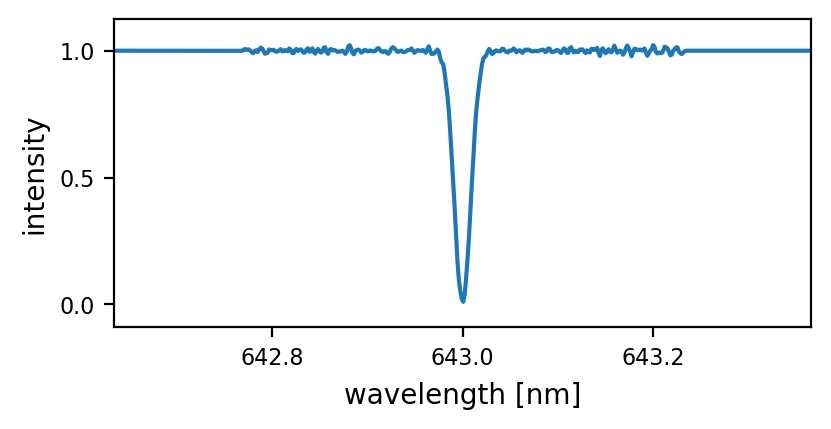

In [7]:
reset_spectrum(map)
map.solve(flux0, normalized=False, fix_map=True, flux_err=settings["flux_err"])
map.visualize(backend="matplotlib", show_maps=False)

#### Normalized solve

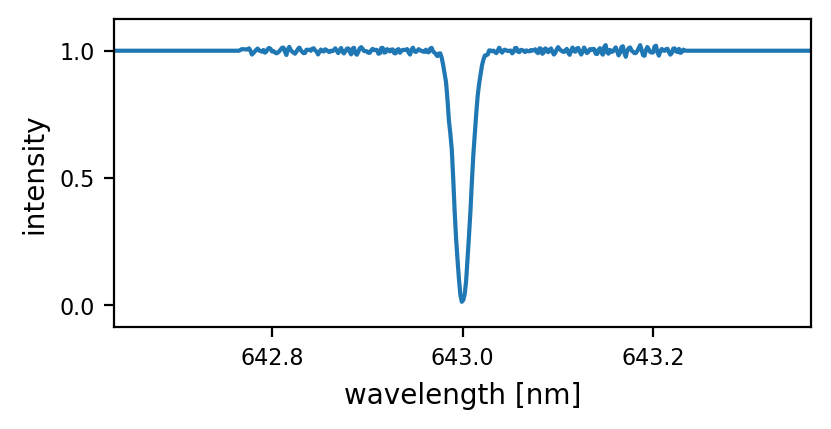

In [8]:
reset_spectrum(map)
map.solve(flux, normalized=True, fix_map=True, flux_err=settings["flux_err"])
map.visualize(backend="matplotlib", show_maps=False)

### Two components

#### Generate the data

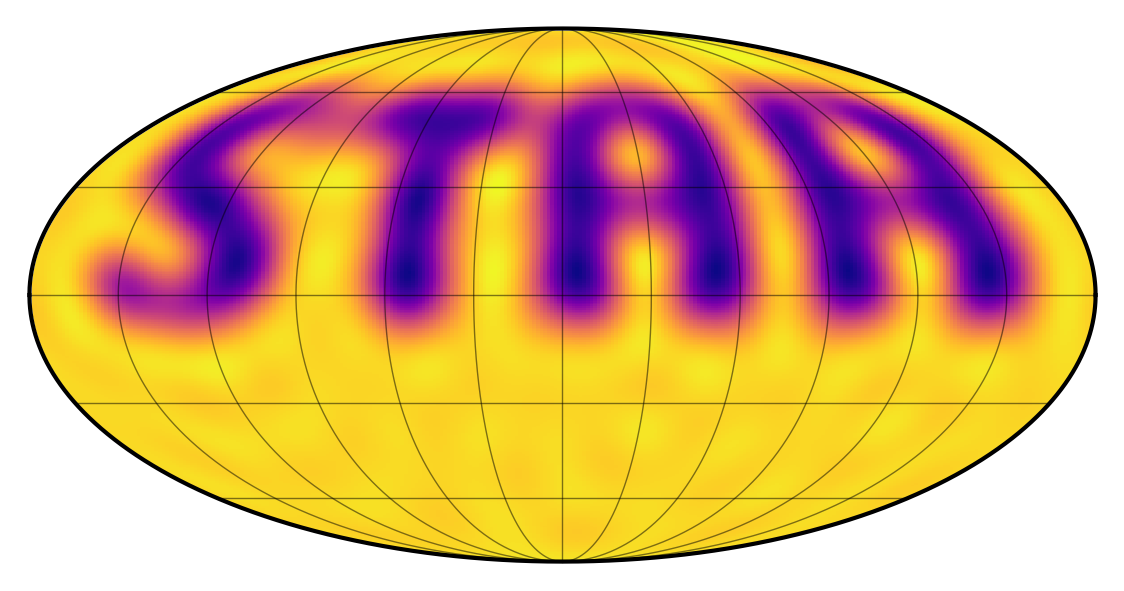

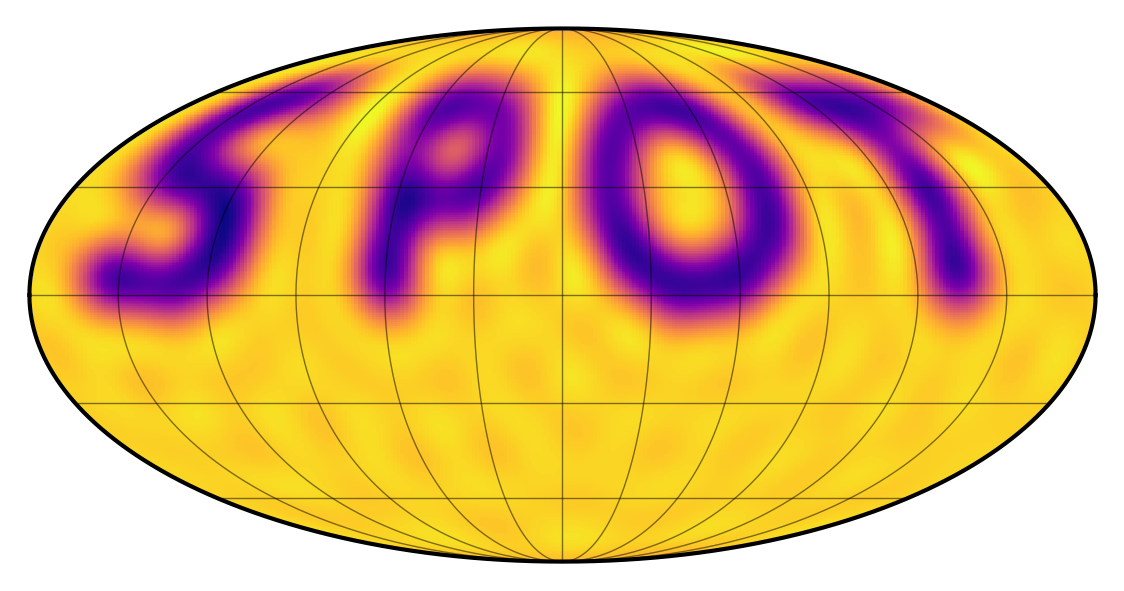

In [9]:
settings = dict(
    flux_err=1e-4, ydeg=15, nt=16, inc=40, veq=60000, smoothing=0.075
)
map, y, spectrum, flux0, flux = generate(nc=2, **settings)

#### Unnormalized solve

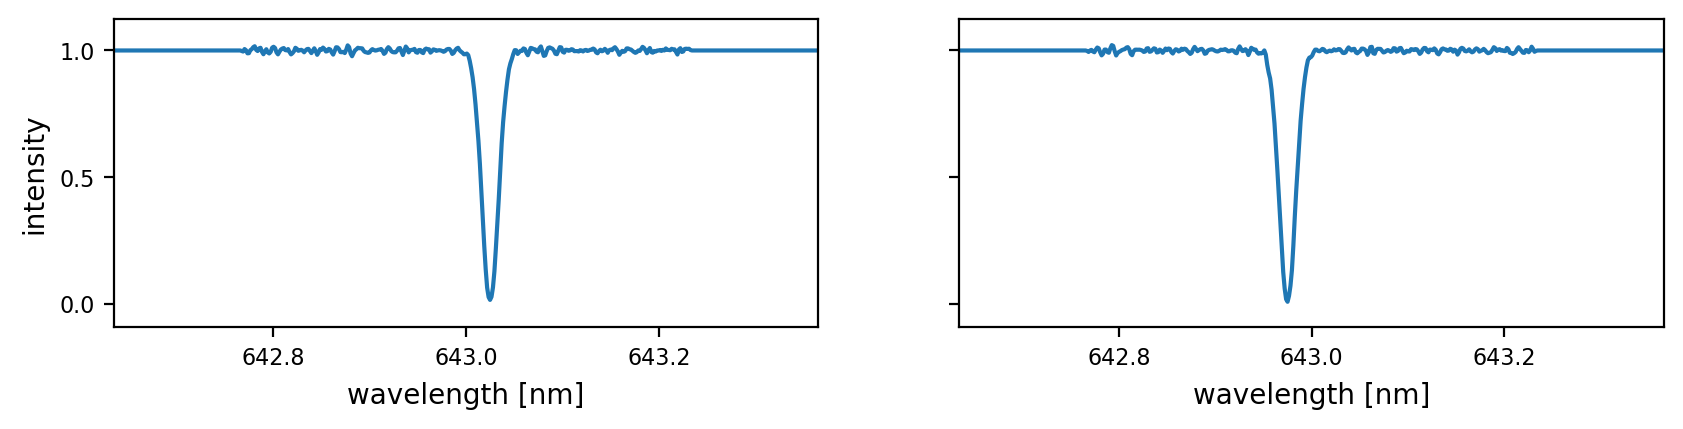

In [10]:
reset_spectrum(map)
map.solve(flux0, normalized=False, fix_map=True, flux_err=settings["flux_err"])
map.visualize(backend="matplotlib", show_maps=False)

#### Normalized solve

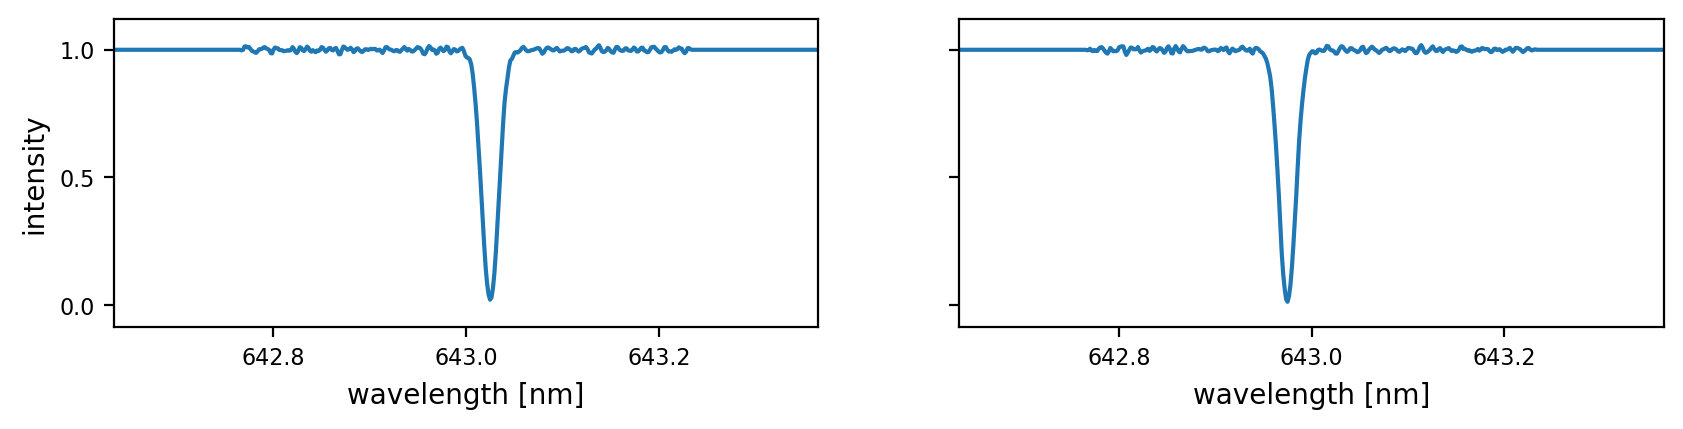

In [11]:
reset_spectrum(map)
map.solve(flux, normalized=True, fix_map=True, flux_err=settings["flux_err"])
map.visualize(backend="matplotlib", show_maps=False)

## Solve for the map

### One component

#### Generate the data

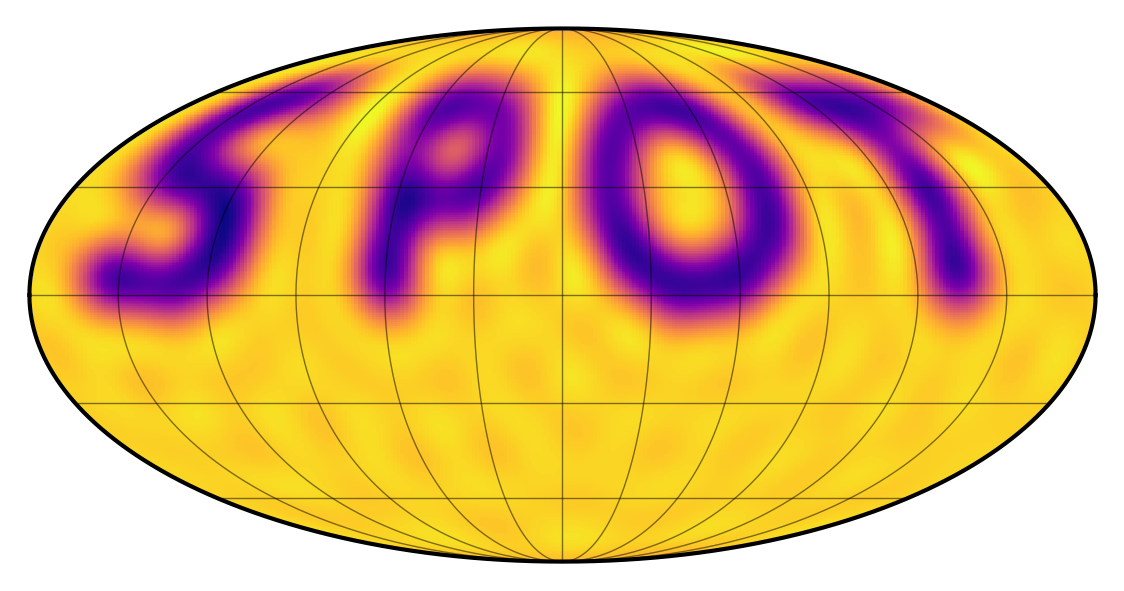

In [12]:
settings = dict(
    flux_err=1e-4, ydeg=15, nt=16, inc=40, veq=60000, smoothing=0.075
)
map, y, spectrum, flux0, flux = generate(nc=1, **settings)

#### Unnormalized solve

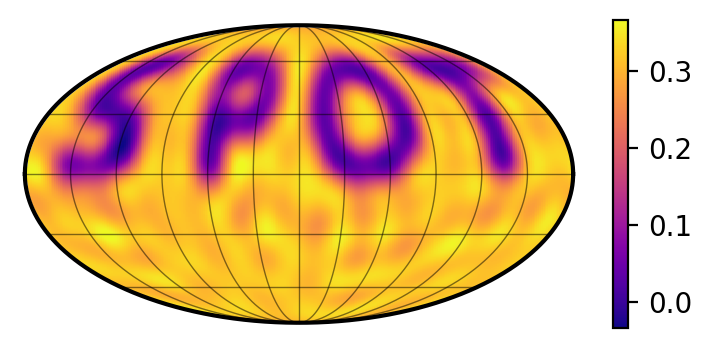

In [13]:
reset_map(map)
map.solve(
    flux0, normalized=False, fix_spectrum=True, flux_err=settings["flux_err"]
)
map.visualize(backend="matplotlib", show_spectra=False)

#### Normalized solve w/ tempering

In [ ]:
reset_map(map)
map.solve(
    flux,
    normalized=True,
    fix_spectrum=True,
    flux_err=settings["flux_err"],
    logT0=12,
)
map.visualize(backend="matplotlib", show_spectra=False)

### Two components

#### Generate the data

In [ ]:
settings = dict(
    flux_err=1e-4, ydeg=15, nt=16, inc=40, veq=60000, smoothing=0.075
)
map, y, spectrum, flux0, flux = generate(nc=2, **settings)

#### Unnormalized solve

In [ ]:
reset_map(map)
map.solve(
    flux0, normalized=False, fix_spectrum=True, flux_err=settings["flux_err"]
)
map.visualize(backend="matplotlib", show_spectra=False)

#### Normalized solve w/ tempering

In [ ]:
reset_map(map)
map.solve(
    flux,
    normalized=True,
    fix_spectrum=True,
    flux_err=settings["flux_err"],
    logT0=12,
)
map.visualize(backend="matplotlib", show_spectra=False)

## Solve for everything

### One component

#### Generate the data

In [ ]:
settings = dict(
    flux_err=1e-4, ydeg=15, nt=16, inc=40, veq=60000, smoothing=0.075
)
map, y, spectrum, flux0, flux = generate(nc=1, **settings)

#### Unnormalized solve

In [ ]:
spectral_cov = george.GP(
    1e-2 * george.kernels.Matern32Kernel(1e-3)
).get_matrix(map.wav0)
info = map.solve(
    flux0,
    normalized=False,
    flux_err=settings["flux_err"],
    logT0=2,
    spectral_cov=spectral_cov,
)
map.visualize(backend="matplotlib")

#### Normalized solve

In [ ]:
spectral_cov = george.GP(
    1e-2 * george.kernels.Matern32Kernel(1e-3)
).get_matrix(map.wav0)
map.solve(
    flux,
    normalized=True,
    flux_err=settings["flux_err"],
    logT0=2,
    spectral_cov=spectral_cov,
)
map.visualize(backend="matplotlib")

### Two components

This is in general very hard to do without good prior information! See the separate notebook on the general two-component problem.